In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time

In [2]:
# ===== 1. Transformasi data (augmentasi + normalisasi) =====
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
# ===== 2. Load dataset dari folder =====
train_dir = '/kaggle/input/responsi-komputasi-statistika-2/Dataset-Responsi/Train'
val_dir = '/kaggle/input/responsi-komputasi-statistika-2/Dataset-Responsi/Validation'

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


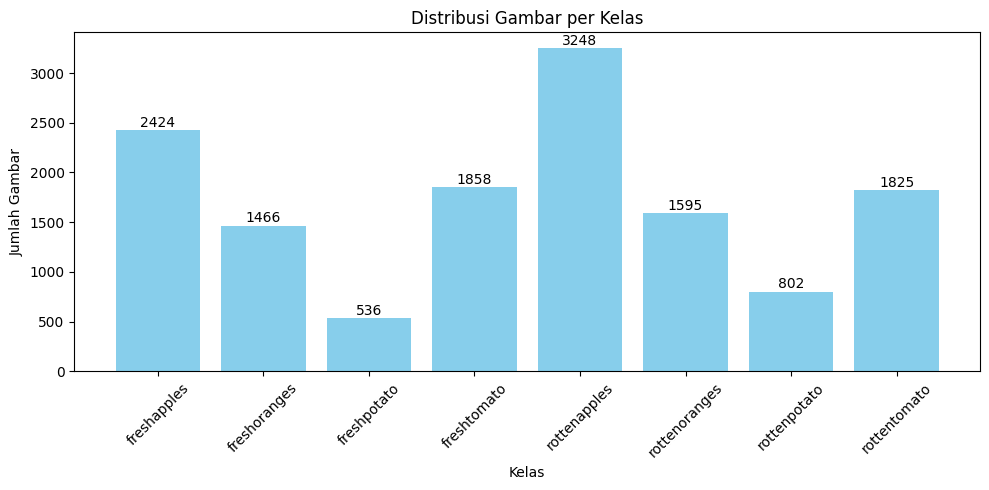

In [4]:
# Eksplorasi Data

import matplotlib.pyplot as plt

class_names = train_dataset.classes  # Nama kelas
class_to_idx = train_dataset.class_to_idx  # Pemetaan nama ke indeks
class_counts = {cls: 0 for cls in class_names}

# Hitung gambar per kelas
for _, label in train_dataset.samples:
    class_name = class_names[label]
    class_counts[class_name] += 1
    
plt.figure(figsize=(10, 5))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

# Visualisasi
plt.xticks(rotation=45)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
#simpan gambar
plt.savefig("distribusi_kelas.png")

plt.show()

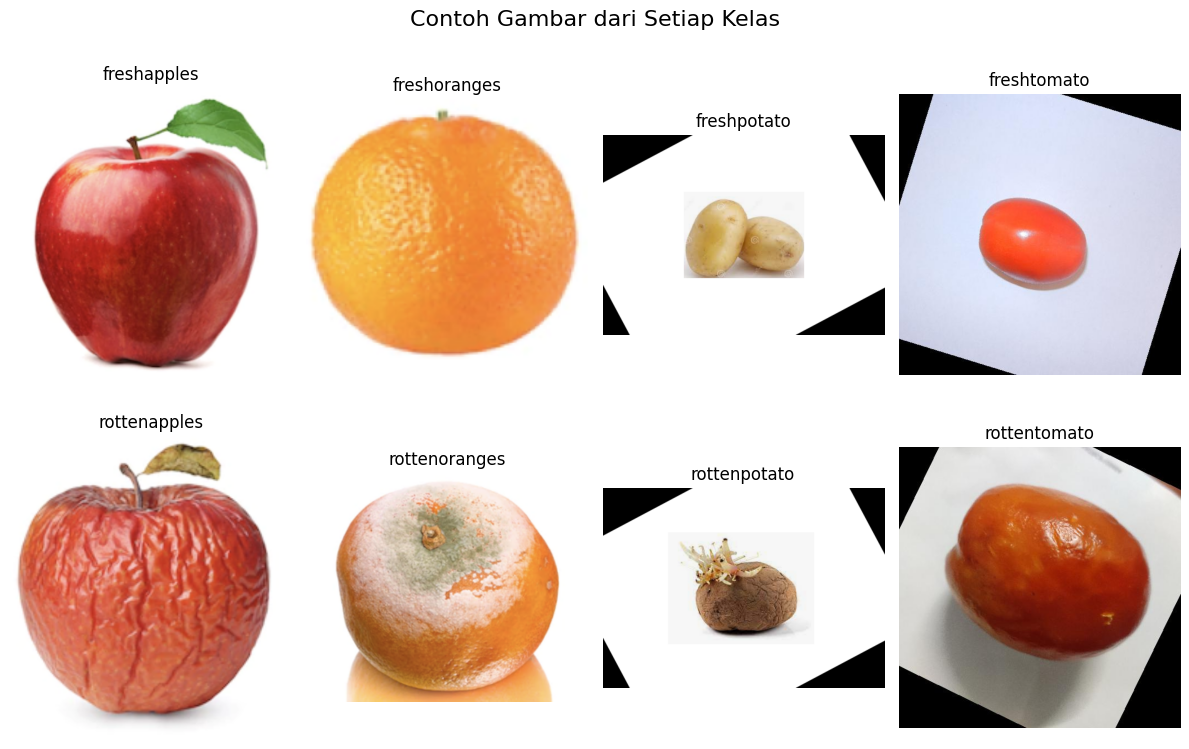

In [5]:
from PIL import Image

plt.figure(figsize=(12, 8))
shown = set()
i = 1
for path, label in train_dataset.samples:
    class_name = class_names[label]
    if class_name not in shown:
        img = Image.open(path)
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
        shown.add(class_name)
        i += 1
    if i > 8:
        break
plt.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=16)
plt.tight_layout()

#simpan gambar
plt.savefig("contohtiapkelas.png")
plt.show()


In [6]:
# ===== 3. Load ResNet50 pretrained =====
model = models.resnet50(pretrained=True)

# Ganti fully connected layer agar output-nya 8 kelas
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)  # 8 = jumlah kelas

model = model.cuda() if torch.cuda.is_available() else model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


In [7]:
# ===== 4. Loss function dan optimizer =====
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
import torch
import matplotlib.pyplot as plt

# Move model to available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize lists to store metrics
train_losses = []
train_accuracies = []

epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate epoch metrics
    epoch_loss = running_loss / total_samples
    epoch_acc = correct / total_samples
    
    # Store metrics for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/15, Loss: 0.1472, Accuracy: 0.9535
Epoch 2/15, Loss: 0.0399, Accuracy: 0.9876
Epoch 3/15, Loss: 0.0276, Accuracy: 0.9915
Epoch 4/15, Loss: 0.0223, Accuracy: 0.9929
Epoch 5/15, Loss: 0.0311, Accuracy: 0.9903
Epoch 6/15, Loss: 0.0144, Accuracy: 0.9953
Epoch 7/15, Loss: 0.0206, Accuracy: 0.9936
Epoch 8/15, Loss: 0.0201, Accuracy: 0.9939
Epoch 9/15, Loss: 0.0127, Accuracy: 0.9965
Epoch 10/15, Loss: 0.0249, Accuracy: 0.9925
Epoch 11/15, Loss: 0.0106, Accuracy: 0.9971
Epoch 12/15, Loss: 0.0075, Accuracy: 0.9974
Epoch 13/15, Loss: 0.0156, Accuracy: 0.9943
Epoch 14/15, Loss: 0.0087, Accuracy: 0.9972
Epoch 15/15, Loss: 0.0186, Accuracy: 0.9943


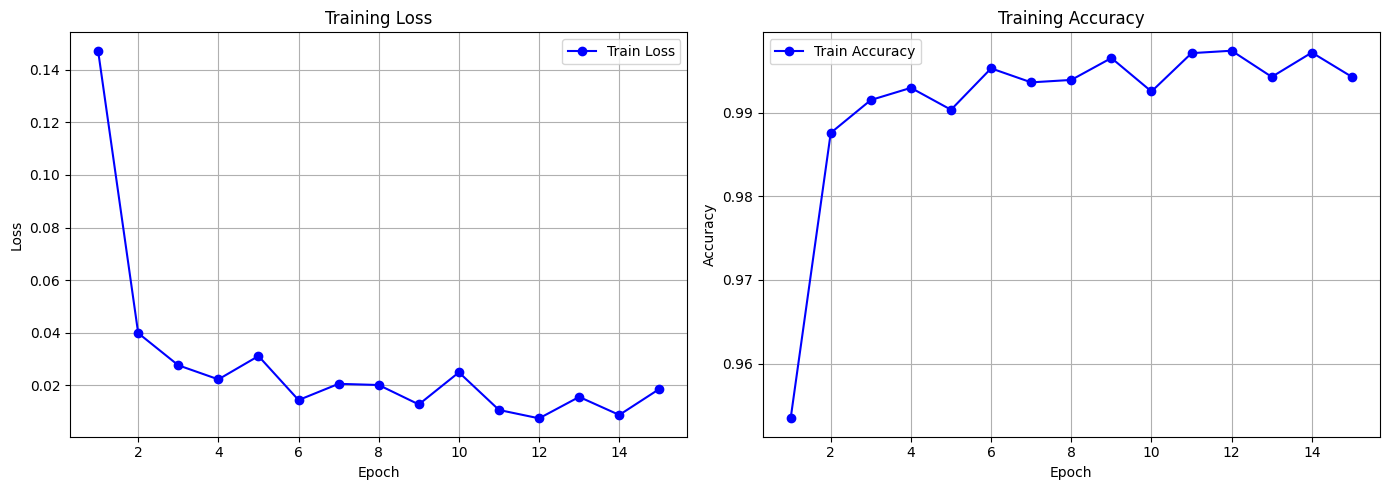

In [9]:
# Plotting
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-o', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, 'b-o', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# ===== 6. Validasi =====
model.eval()
correct = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.cuda(), labels.cuda() if torch.cuda.is_available() else (inputs, labels)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

val_acc = correct / len(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.9963


<Figure size 1000x800 with 0 Axes>

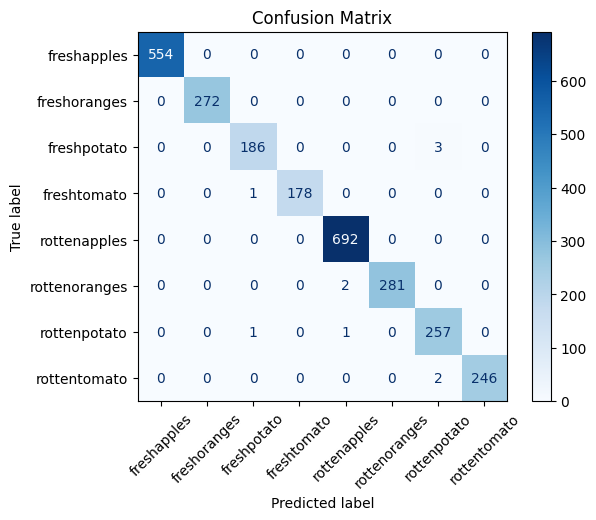

Classification Report:

               precision    recall  f1-score   support

  freshapples       1.00      1.00      1.00       554
 freshoranges       1.00      1.00      1.00       272
  freshpotato       0.99      0.98      0.99       189
  freshtomato       1.00      0.99      1.00       179
 rottenapples       1.00      1.00      1.00       692
rottenoranges       1.00      0.99      1.00       283
 rottenpotato       0.98      0.99      0.99       259
 rottentomato       1.00      0.99      1.00       248

     accuracy                           1.00      2676
    macro avg       1.00      0.99      1.00      2676
 weighted avg       1.00      1.00      1.00      2676



In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Inisialisasi
all_preds = []
all_labels = []

# Kumpulkan prediksi dan label aktual
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.cuda(), labels.cuda() if torch.cuda.is_available() else (inputs, labels)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))


In [12]:
import os
from PIL import Image
import torch
from torchvision import transforms
import pandas as pd

# Path ke folder test
test_folder = '/kaggle/input/responsi-komputasi-statistika-2/Dataset-Responsi/Test'  # ganti sesuai path

# Transformasi (sesuai training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Pastikan model dalam mode eval
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
import os
import torch
from PIL import Image
import pandas as pd

# Mapping label -> kode
label_encoding = {
    'freshapples': 1,
    'freshoranges': 2,
    'freshpotato': 3,
    'freshtomato': 4,
    'rottenapples': 5,
    'rottenoranges': 6,
    'rottenpotato': 7,
    'rottentomato': 8
}

class_names = train_dataset.class_to_idx  # {'freshapples': 0, ..., 'rottentomato': 7}
idx_to_class = {v: k for k, v in class_names.items()}  # {0: 'freshapples', ..., 7: 'rottentomato'}


# Folder gambar test
test_folder = '/kaggle/input/responsi-komputasi-statistika-2/Dataset-Responsi/Test'

# Simpan hasil prediksi
results = []

# Loop semua gambar di folder test
for img_name in sorted(os.listdir(test_folder)):  # ✅ Sort berdasarkan nama
    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(test_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)
            pred_class_name = idx_to_class[pred.item()]
            pred_class_code = label_encoding[pred_class_name]

        results.append({
            'image': img_name,
            'label': pred_class_code
        })




In [14]:
# Simpan ke CSV
df = pd.DataFrame(results)
df.to_csv('BISMILLAH.csv', index=False)

In [15]:
best_val_acc = 0.0

for epoch in range(epochs):

    # === Simpan model jika val_acc membaik ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')  # ⬅️ Disinilah file akan dibuat
        print("Model disimpan.")


Model disimpan.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hoo

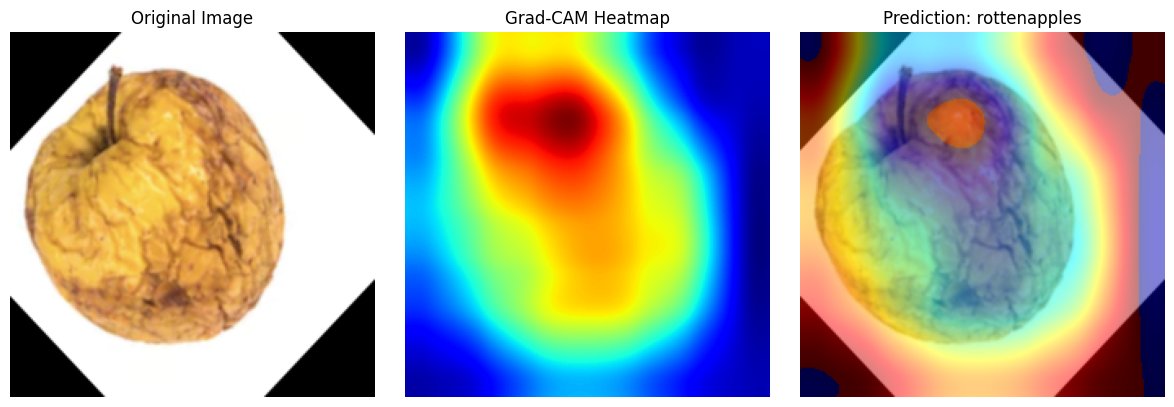

In [16]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
import os

# === Konfigurasi ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model dan ubah output layer
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 8)
model.load_state_dict(torch.load('/kaggle/working/best_model.pth', map_location=device))  # ganti dengan path model kamu
model = model.to(device)
model.eval()

# Transformasi (harus sama dengan saat training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Mapping index ke label
idx_to_class = {
    0: 'freshapples', 1: 'freshoranges', 2: 'freshpotato', 3: 'freshtomato',
    4: 'rottenapples', 5: 'rottenoranges', 6: 'rottenpotato', 7: 'rottentomato'
}

# === Grad-CAM function ===
def generate_gradcam(model, input_tensor, target_layer='layer4'):
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    for name, module in model.named_modules():
        if name == target_layer:
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    score = output[0, pred_class]
    model.zero_grad()
    score.backward()

    grad = gradients[0]
    act = activations[0]
    pooled_grad = torch.mean(grad, dim=(0, 2, 3))

    for i in range(act.shape[1]):
        act[:, i, :, :] *= pooled_grad[i]

    heatmap = act.mean(dim=1).squeeze()
    heatmap = torch.relu(heatmap)
    heatmap /= torch.max(heatmap)
    return heatmap.detach().cpu().numpy(), pred_class

# === Pilih satu gambar dari folder test ===
img_path = '/kaggle/input/responsi-komputasi-statistika-2/Dataset-Responsi/Test/img_0007.png'  # ganti sesuai file yang tersedia
img_pil = Image.open(img_path).convert('RGB')
img_tensor = transform(img_pil).unsqueeze(0).to(device)

# Grad-CAM
heatmap, pred_idx = generate_gradcam(model, img_tensor)
pred_label = idx_to_class[pred_idx]

# Visualisasi
img_np = np.array(img_pil.resize((224, 224)))
heatmap_resized = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_CUBIC)
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.5, heatmap_color, 0.5, 0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Prediction: {pred_label}")
plt.axis('off')

plt.tight_layout()
plt.show()
